In [3]:
import torch
from torch import nn
from PIL import Image

from tqdm import tqdm

from myutils.depth import *
from myutils.dino1 import load_dino1_model
from myutils.dino2 import load_dino2_model
from myutils.discovery import *
from myutils.pascal_voc import *
from myutils.ssl import *
from myutils.utils import *
from myutils.datasets import bbox_iou

import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

from transformers import  DPTForDepthEstimation, DPTImageProcessor

import base64
import json
import argparse

import random

dataset_path = "datasets/VOC2007/VOCdevkit/VOC2007"

images = ['005881', '000250', '001855', '007586', '009079', '003159', '009745', '004801', '004244', '006185', '002405', '000334', '008349', '007853', '001263', '007193', '008856', '003678', '008833', '000109', '002873', '009881', '007040', '007751', '008917', '003369', '003629', '004828', '004192', '008415', '008733', '009418', '006694', '005676', '006339', '001590', '004281', '008096', '009438', '006212', '005064', '008372', '009343', '001185', '009307', '003433', '002266', '009214', '009421', '007417', '000951', '004359', '005732', '007697', '001981', '003147', '002224', '003051', '004706', '000047', '001393', '001510', '002977', '003994', '002880', '005790', '006247', '006282', '004441', '006822', '006626', '007398', '007261', '009246', '007503', '001343', '001250', '003807', '000667', '003120', '000489', '007372', '001455', '000470', '004797', '005101', '000917', '005312', '007847', '009904', '006425', '000483', '001927', '009331', '004518', '000173', '002439', '005365', '007621', '006968']


/opt/homebrew/Caskroom/miniconda/base/envs/ssl-fede/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/fedegonzal/Documents/ub/scope/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
# dino v1
params = {
    'patch_size': 16,
    'ssl_checkpoint': 'pretrained/dino_deitsmall16_pretrain.pth',
    'depth_checkpoint': 'Intel/dpt-hybrid-midas',
    'img_size': None
}

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def compute_attention_sparsity(attention_map):
    # Thresholding the map for sparse/non-sparse distinction
    threshold = 0.5  # Adjustable based on your data
    sparsity = np.count_nonzero(attention_map > threshold) / attention_map.size
    return sparsity


Attention sparsity: 0.008266666666666667
Weighted attention: 0.9918011108172441
Image name: 001510
Estimated noise: 23.848895715940525
Entropy: 4.236413853010798


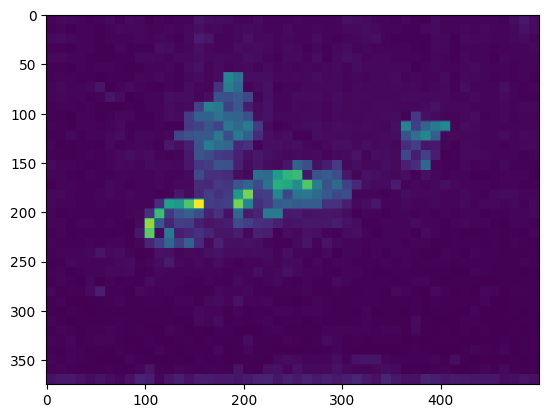

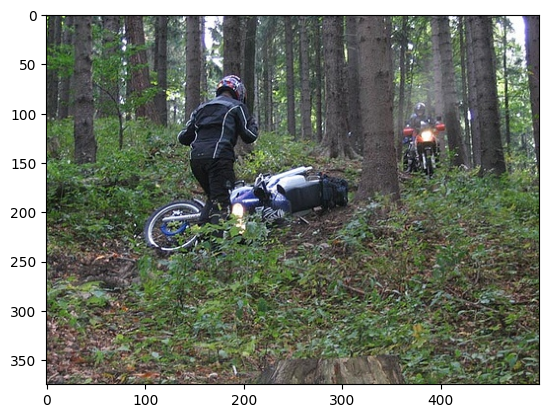

In [10]:
# Let's take a random image from the images list
rand = random.randint(0, len(images)-1)
img_name = images[rand]

# Let's get the image path and annotation path
image_path = f'{dataset_path}/JPEGImages/{img_name}.jpg'
annotation_path = f'{dataset_path}/Annotations/{img_name}.xml'

# let's show the image
pil_img = load_image_as_pil(image_path)

# Convert to tensor and transform
img_tensor = load_image_as_tensor(pil_img).to(device)

#########################
# GETTING THE ATTENTION #
#########################

# Padding the image with zeros to fit multiple of patch-size
patch_size = params['patch_size']
img_paded = img_tensor_padded(img_tensor, patch_size).to(device)

# Load the SSL model
model = load_dino1_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
#model = load_dino2_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
model.to(device)
model.eval()

# Get the attentions
atts = get_attentions(model, img_paded, patch_size)

# Obtain the attention map

# Sum the attention outputs (6 outputs used in DINO)
sum_atts = atts.sum(0)

# Resize the attentions to the original image size
sum_atts_resized = cv2.resize(sum_atts, (pil_img.width, pil_img.height))

# Normalize the attention map to [0, 1]
sum_atts_resized_norm = (sum_atts_resized - sum_atts_resized.min()) / (sum_atts_resized.max() - sum_atts_resized.min())

# Sparsity for Attention Map
# Calculate sparsity by measuring the non-zero values (concentration) in the attention map.
attention_sparsity = compute_attention_sparsity(sum_atts_resized_norm)
w_attention = 1 / (1 + attention_sparsity)  # Lower sparsity -> higher weight
print(f"Attention sparsity: {attention_sparsity}")
print(f"Weighted attention: {w_attention}")

noise = estimate_noise(sum_atts)
entropy = calculate_entropy(sum_atts)

print(f"Image name: {img_name}")
print(f"Estimated noise: {noise}")
print(f"Entropy: {entropy}")

plt.imshow(sum_atts_resized)
plt.show()

plt.imshow(pil_img)
plt.show()

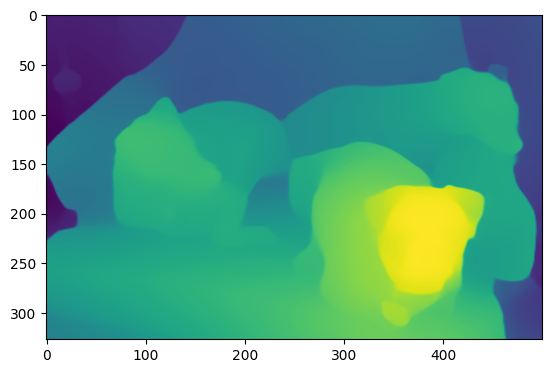

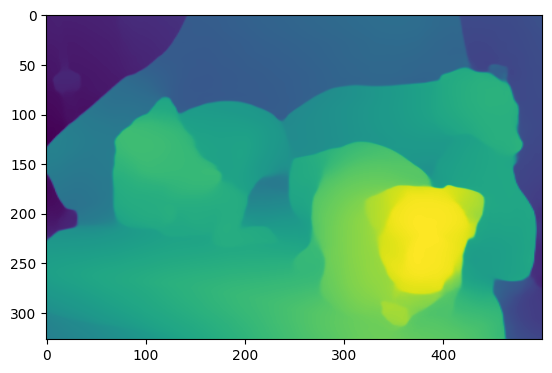

In [6]:
#################
# GETTING DEPTH #
#################

# Get the depth prediction
depth_feats, depth_image = get_depth_prediction(pil_img, params['depth_checkpoint'])

# Obtain the depth map

# Resize depth_image to the original image size
numpy_depth_image = depth_image.squeeze(0).cpu().numpy()
depth_image_resized = cv2.resize(numpy_depth_image, pil_img.size)

plt.imshow(depth_image_resized)
plt.show()

# Normalizing depth
depth_image_resized_norm = (depth_image_resized - np.min(depth_image_resized)) / (np.max(depth_image_resized) - np.min(depth_image_resized))

plt.imshow(depth_image_resized_norm)
plt.show()


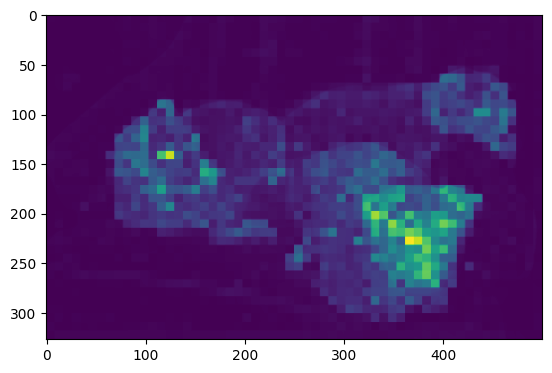

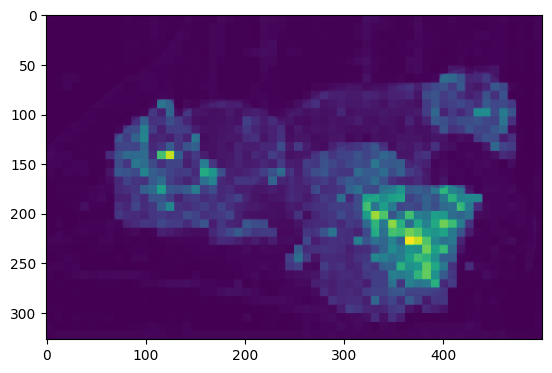

In [7]:
############################
# FINAL ATT * GLOBAL DEPTH #
############################

# final attention map (depth * att)
final_attention_map = depth_image_resized_norm * sum_atts_resized_norm

plt.imshow(final_attention_map)
plt.show()

# Normalize final_attention_map from 0 to 255
final_attention_map_255 = (final_attention_map - np.min(final_attention_map)) / (np.max(final_attention_map) - np.min(final_attention_map)) * 255
final_attention_map_255 = final_attention_map_255.astype(np.uint8)

plt.imshow(final_attention_map_255)
plt.show()


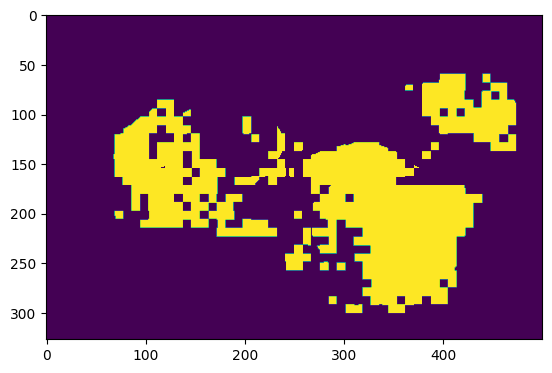

In [8]:
# Apply a binary threshold to the image
_, final_att_thresholded = cv2.threshold(final_attention_map_255, final_attention_map_255.std(), 255, cv2.THRESH_BINARY)

plt.imshow(final_att_thresholded)
plt.show()


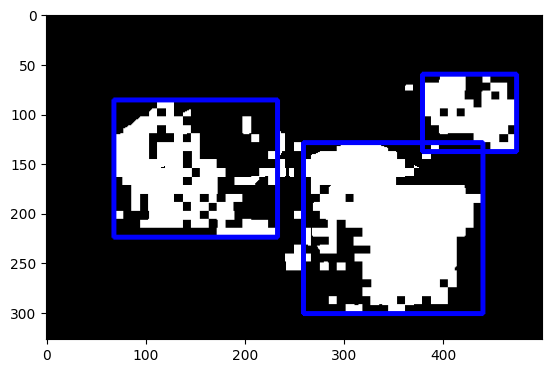

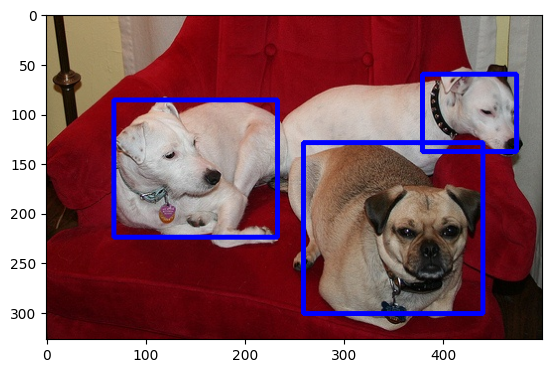

In [9]:
thresh_image = final_att_thresholded.copy()
original_image = pil_img.copy()

# convert to numpy
original_image = np.array(original_image)

# inverting the image
#thresh_image = cv2.bitwise_not(thresh_image)

layer_predicted_boxes = get_boxes(thresh_image)


# let's convert thresh_image to color
thresh_image = cv2.cvtColor(thresh_image, cv2.COLOR_GRAY2RGB)


# Draw the matched boxes for countours
for i, contour in enumerate(layer_predicted_boxes):

    color = (0, 0, 255)
    thickness = 3
    x, y, w, h = contour
    cv2.rectangle(thresh_image, (x, y), (x + w, y + h), color, thickness)

plt.imshow(thresh_image)
plt.show()

# Draw the matched boxes over the original image
for i, contour in enumerate(layer_predicted_boxes):

    color = (0, 0, 255)
    thickness = 3
    x, y, w, h = contour
    cv2.rectangle(original_image, (x, y), (x + w, y + h), color, thickness)

plt.imshow(original_image)
plt.show()


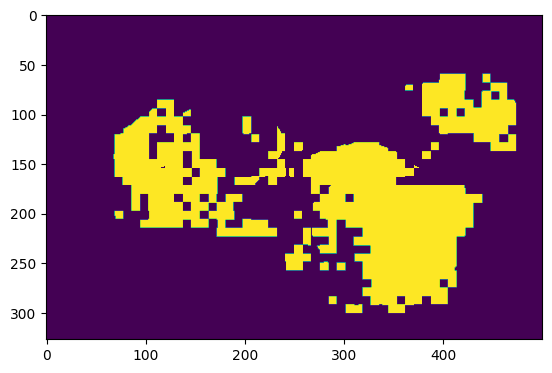

In [38]:
thresh_image = final_attention_map_255.copy()
std = final_attention_map_255.std()

# let's convert the final image in this way:
# 1. each pixel greater than std() will be 255
# 2. each pixel less than std() will be 0

thresh_image[thresh_image > std] = 255
thresh_image[thresh_image <= std] = 0

plt.imshow(thresh_image)
plt.show()


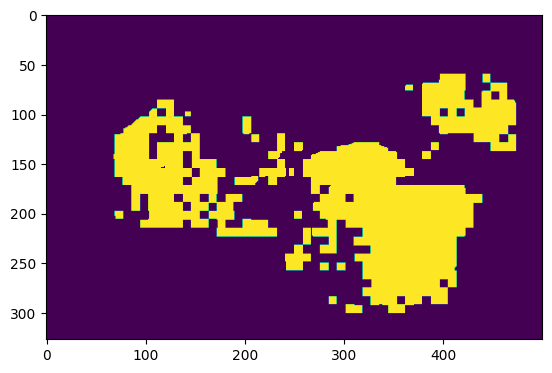

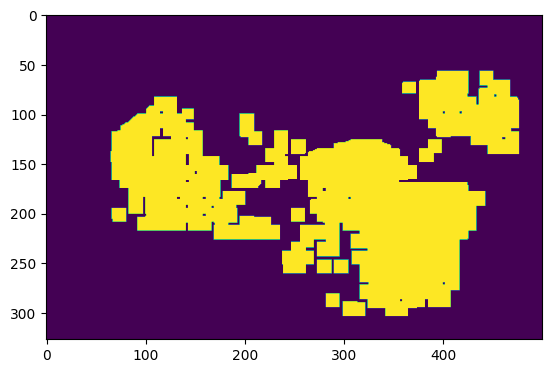

In [39]:
# Noise removal using morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh_image, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area using distance transform
#dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)


plt.imshow(opening)
plt.show()

plt.imshow(sure_bg)
plt.show()


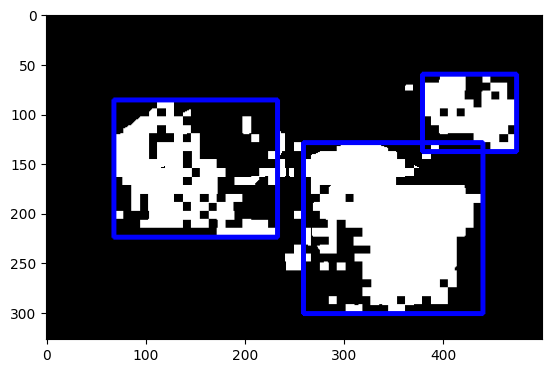

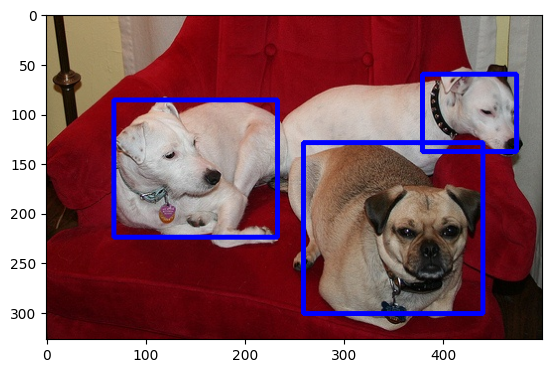

In [41]:
thresh_image = final_att_thresholded.copy()
original_image = pil_img.copy()

# convert to numpy
original_image = np.array(original_image)

# inverting the image
#thresh_image = cv2.bitwise_not(thresh_image)

layer_predicted_boxes = get_boxes(thresh_image)

# Find the contours
contours, hierarchy = cv2.findContours(thresh_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

the_contours = []

# Draw the contours with different colors
for i, contour in enumerate(contours):

    # Using hierarchy to filter out the inner contours
    if hierarchy[0][i][3] != -1:
        continue

    # if the contour is too small, ignore it
    if cv2.contourArea(contour) < 1000:
        continue

    # Approximate the contour with a rectangle
    x, y, w, h = cv2.boundingRect(contour)    
    the_contours.append([x, y, w, h])

layer_predicted_boxes = the_contours

# let's convert thresh_image to color
thresh_image = cv2.cvtColor(thresh_image, cv2.COLOR_GRAY2RGB)


# Draw the matched boxes for countours
for i, contour in enumerate(layer_predicted_boxes):

    color = (0, 0, 255)
    thickness = 3
    x, y, w, h = contour
    cv2.rectangle(thresh_image, (x, y), (x + w, y + h), color, thickness)

plt.imshow(thresh_image)
plt.show()

# Draw the matched boxes over the original image
for i, contour in enumerate(layer_predicted_boxes):

    color = (0, 0, 255)
    thickness = 3
    x, y, w, h = contour
    cv2.rectangle(original_image, (x, y), (x + w, y + h), color, thickness)

plt.imshow(original_image)
plt.show()


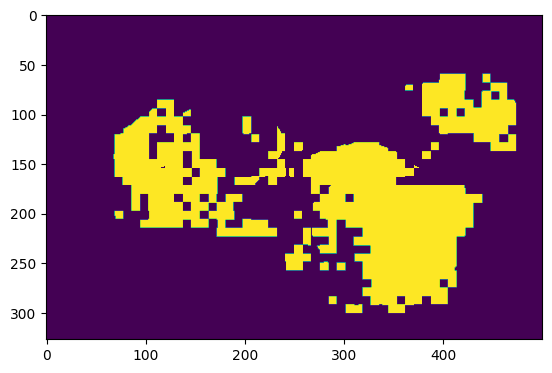

In [9]:
########################
# THRESHOLDED & RESULT #
########################

# Apply a binary threshold to the image
_, final_att_thresholded = cv2.threshold(final_attention_map_255, final_attention_map_255.std(), 255, cv2.THRESH_BINARY)

# Get the predicted boxes from the final image using contours
predicted_boxes = get_boxes(final_att_thresholded)

plt.imshow(final_att_thresholded)
plt.show()


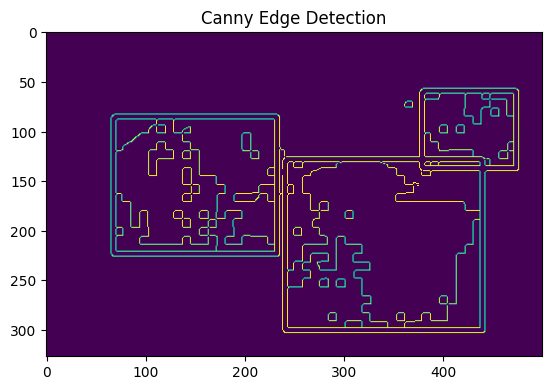

In [32]:
final_image = thresh_image.copy()

# Apply Canny Edge Detection
edges = cv2.Canny(final_image, threshold1=100, threshold2=200)

# Show the result
plt.imshow(edges)
plt.title('Canny Edge Detection')
plt.show()


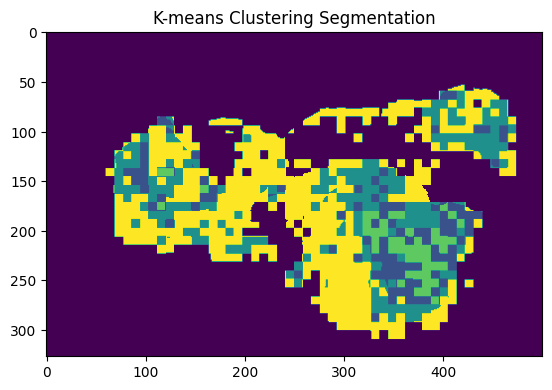

In [46]:
final_image = final_attention_map_255.copy()

# Reshape the image to a 2D array of pixels
pixels = final_image.reshape(-1, 1)

# Apply K-means clustering
k = 5  # Number of clusters (you can increase this value)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(np.float32(pixels), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert the labels back into an image
segmented_image = labels.reshape(final_image.shape)

# Show the result
plt.imshow(segmented_image)
plt.title('K-means Clustering Segmentation')
plt.show()


In [34]:
thresh = thresh_image.copy()

# Convert to a binary image
#_, thresh = cv2.threshold(final_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(cv2.cvtColor(final_image, cv2.COLOR_GRAY2BGR), markers)
final_image[markers == -1] = [255]

# Show the result
plt.imshow(final_image)
plt.title('Final attention map')
plt.show()

plt.imshow(thresh)
plt.title('Thresholded')
plt.show()


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/distransform.cpp:752: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'distanceTransform'


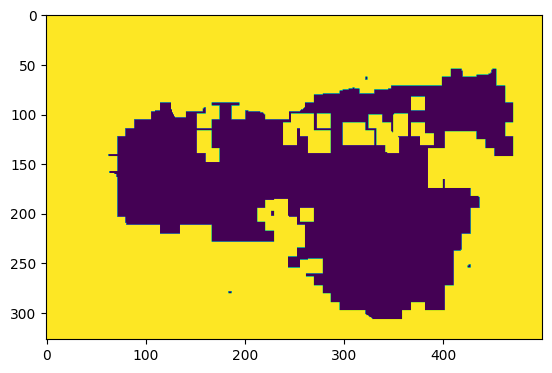

In [36]:
plt.imshow(sure_bg)
plt.show()


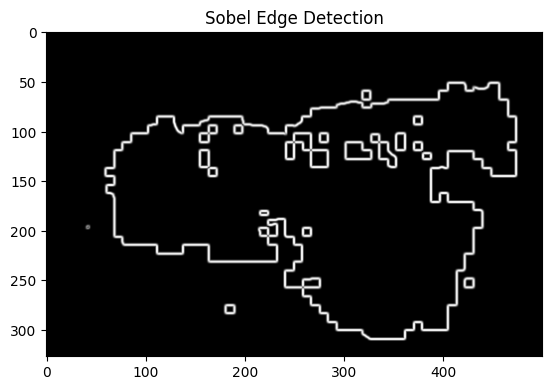

In [13]:
final_image = thresh_image.copy()

# Apply Sobel Operator
sobelx = cv2.Sobel(final_image, cv2.CV_64F, 1, 0, ksize=5)  # Gradient in X direction
sobely = cv2.Sobel(final_image, cv2.CV_64F, 0, 1, ksize=5)  # Gradient in Y direction
sobel_combined = cv2.magnitude(sobelx, sobely)

# Show the result
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Edge Detection')
plt.show()


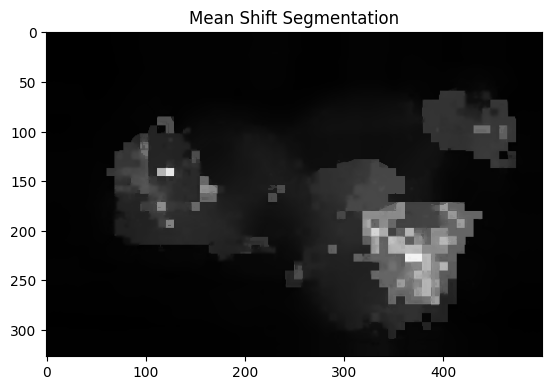

In [14]:
final_image = final_attention_map_255.copy()


# Apply Mean Shift Filtering (for segmentation)
image_bgr = cv2.cvtColor(final_image, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels for MeanShift
mean_shift = cv2.pyrMeanShiftFiltering(image_bgr, sp=20, sr=40)

# Show the result
plt.imshow(mean_shift)
plt.title('Mean Shift Segmentation')
plt.show()


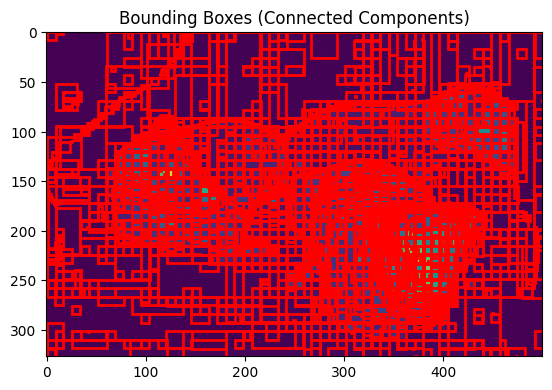

In [50]:
from skimage.measure import label, regionprops

combined_features = final_attention_map_255.copy()

# Threshold the combined features
#threshold = np.mean(combined_features)
#binary_mask = np.mean(combined_features, axis=0) > threshold

# Connected component analysis
labels = label(combined_features)
props = regionprops(labels)

# Draw bounding boxes
fig, ax = plt.subplots()
ax.imshow(combined_features)

for prop in props:
    minr, minc, maxr, maxc = prop.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.title('Bounding Boxes (Connected Components)')
plt.show()


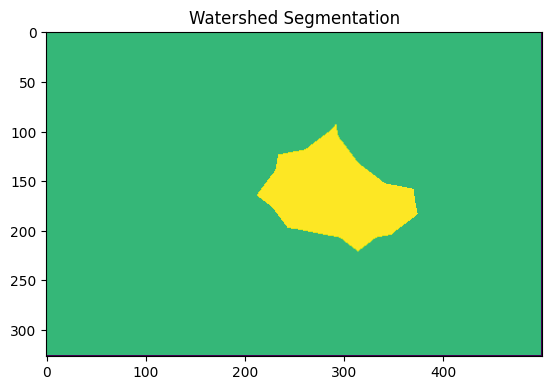

In [52]:
import cv2

# Use OpenCV's watershed for object detection
#gray = np.uint8(combined_features * 255)
gray = combined_features
dist_transform = cv2.distanceTransform(gray, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find contours for the watershed algorithm
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(gray, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

# Apply watershed
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), markers)

# Generate bounding boxes from markers
plt.imshow(markers)
plt.title('Watershed Segmentation')
plt.show()


In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

reduced_features = final_attention_map_255.copy()

# Combined features from DINO + Depth
# Assuming 'reduced_features' is your 2D combined feature map from previous steps

# Initialize mask with "probably background"
mask = np.zeros(reduced_features.shape, np.uint8)  # Initial mask
height, width = reduced_features.shape

# Create a bounding rectangle around the probable objects (for GrabCut initialization)
rect = (10, 10, width - 20, height - 20)  # Adjust these values as needed

# Initialize models for GrabCut
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Apply GrabCut (interactive segmentation based on initial mask)
# 'iterCount' specifies how many times the algorithm iterates to refine the boundary
cv2.grabCut(cv2.normalize(reduced_features, None, 0, 255, cv2.NORM_MINMAX).astype('uint8'),
            mask, rect, bgd_model, fgd_model, iterCount=5, mode=cv2.GC_INIT_WITH_RECT)

# Final mask where we have the segmentation result
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
segmented = reduced_features * mask2  # Apply mask to the feature map

# Display result
plt.imshow(segmented, cmap='gray')
plt.title("GrabCut Result")
plt.show()


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/grabcut.cpp:557: error: (-5:Bad argument) image must have CV_8UC3 type in function 'grabCut'
